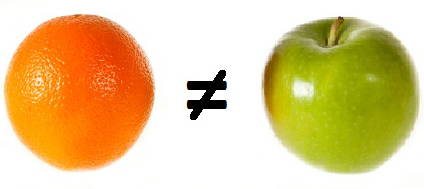

In this post I will walk you through the process of extending the the built-in [Compare-Object](https://docs.microsoft.com/en-us/powershell/module/microsoft.powershell.utility/compare-object?view=powershell-7.1) cmdlet to support "deep" comparison of custom objects, arrays, and classes.

Let's start this journey by creating a simple class that we can use to test the current and future capabilities of Compare-Object.

In [1]:
class Person {
    [String]$Name
    [String]$LastName
    [int]$Age
    [Person[]]$Parents

    Person($Name, $LastName, $Age) {
        $this.Name = $Name
        $this.LastName = $LastName
        $this.Age = $Age
    }
}

The below script needs to be able to find the current output cell; this is an easy method to get it.

We create two virtual families based on this blueprint. Notice that the `Parent` property of the `Person` objects are just arrays of type `Person`.

In [2]:
$psmith = [Person]::new('Paul', 'Smith', 46)
$msmith = [Person]::new('Mary', 'Smith', 35)
$nsmith = [Person]::new('Nigel', 'Smith', 11)
$nsmith.Parents = $psmith, $msmith

$pdoe = [Person]::new('Jon', 'Doe', 46)
$ldoe = [Person]::new('Mary', 'Doe', 51)
$adoe = [Person]::new('Aidan', 'Doe', 23)
$adoe.Parents = $pdoe, $ldoe

Nice, as a next step we'll see what we can do with the built-in Compare-Object cmdlet to explore the differences between Nigel's and Aidan's parents.

In [3]:
Compare-Object $nsmith $adoe

Yes, this is not an error. The command does not lead to any output. For anything else than scalars or arrays of scalars, Compare-Object needs to know which property(ies) we want to compare.

In [4]:
Compare-Object $nsmith $adoe -Property Parents

Dooh, again no output? Let's try another approach.

In [5]:
Compare-Object $nsmith $adoe -Property Parents -IncludeEqual


Parents      SideIndicator
-------      -------------
{Paul, Mary} ==



What is going on here, is that Compare-Object just compares the string representation of the Parents properties

In [6]:
$nsmith.Parents.ToString()
$adoe.Parents.ToString()

Person[]
Person[]


How can we get Compare-Object to actually compare the nested properties of the Parents objects?

In [7]:
Compare-Object $nsmith $adoe -Property {$_.Parents.Name}


$_.Parents.Name SideIndicator
--------------- -------------
{Jon, Mary}     =>
{Paul, Mary}    <=



How about multiple properties?

In [8]:
Compare-Object $nsmith $adoe -Property { $_.Parents.Age }, { $_.Parents.Name }


 $_.Parents.Age   $_.Parents.Name  SideIndicator
---------------- ----------------- -------------
{46, 51}         {Jon, Mary}       =>
{46, 35}         {Paul, Mary}      <=



While this is producing output, it's not really useful nor what one would expect from a Compare-Object cmdlet.Generally, the output of the cmdlet is confusing. Instead of showing the reference- and difference values side-by-side the output is shown in one line per input object instead. One more try ..

In [9]:
Compare-Object $nsmith $adoe -Property { $_.Parents[1].Age }, { $_.Parents[1].Name }


 $_.Parents[1].Age   $_.Parents[1].Name  SideIndicator
------------------- -------------------- -------------
                 51 Mary                 =>
                 35 Mary                 <=



If we specify the nested properties, one by one, through ScriptBlock arguments, we get the expected output. It's time to consider the requirements for an extended version of the cmdlet, that is better able to deal with custom classes and object arrays. Here is what I came up with:

- Iterate over arrays of custom objects and custom classes.
- Iterate over custom objects and custom classes and their properties.
- Show output in 'Property' 'ReferenceValue' 'DifferenceValue' format rather than the default output.
- Ability to specifiy a maximum recursion Depth (how deep we want Compare-Object to iterate over nested objects and properties)
- Extend the built-in Compare-Object rather than creating a separate function.

Before we start building this into the Compare-Object cmdlet (via [proxy function](https://devblogs.microsoft.com/scripting/proxy-functions-spice-up-your-powershell-core-cmdlets/)) we can create a small proof of concept function. The function definitely needs to be able to recognize the input object's "type". While this is easy enough for custom objects and arrays, it turned out to be difficult for custom classes.

In [10]:
$customObj = [PSCustomObject][ordered]@{Prop='value'}
$customObj.GetType()
$customObjArray = ,$customObj, $customObj
'---------'
$customObjArray -is [Array]
'---------'
$adoe.GetType()


IsPublic IsSerial Name                                     BaseType
-------- -------- ----                                     --------
True     False    PSCustomObject                           System.Object
---------
True
---------
True     False    Person                                   System.Object



We can definitely not check for the name of the type for custom classes. Let's see what else is different about such a class as compared to a built-in type or a PSCustomObject Wait, what would we need to figure this out? Yes, a better Compare-Object would come in handy now.

Here is a first proto-type that iterates over a set of properties. It also uses the idea of 'compact' output and works around another problem with the built-in Compare-Object which is that it can't deal with null values. 

In [11]:
function Compare-Stuff($refObject,$diffObject,$props){
    foreach ($prop in ($props)) {
        $ref = $refObject.$prop
        $diff = $diffObject.$prop
        if (!$diff){ $diff = 'null'}
        if (!$ref){ $ref = 'null' }
        $out = Compare-Object $ref $diff | select @{n='Property';e={$prop}}, InputObject, SideIndicator
        $out | Group-Object Property,{$_.SideIndicator -eq '=='} | foreach {
            if ($_.Group[0].SideIndicator -eq '==') {
                [PSCustomObject][Ordered]@{
                    Property        = $_.Group.Property
                    ReferenceValue  = $_.Group.InputObject
                    DifferenceValue = $_.Group.InputObject
                }
            }
            else {
                [PSCustomObject][Ordered]@{
                    Property        = $_.Group[0].Property
                    ReferenceValue  = ($_.Group.where{ $_.SideIndicator -eq '<=' }).InputObject
                    DifferenceValue = ($_.Group.where{ $_.SideIndicator -eq '=>' }).InputObject
                }
            }
        }
    }
}

Let's use it to compare the properties of the different types. After some trial and error I ended up excluding some properties since they contain arrays of values which would be otherwise compared one by one  (we will need to fix this later).

In [12]:
$builtinType = 'test'.GetType()
$personType = $adoe.GetType()
$excludeProps = 'DeclaredFields','Assembly','CustomAttributes','DeclaredConstructors','DeclaredMembers','DeclaredMethods','AssemblyQualifiedName','DeclaredProperties','Attributes','GUID','ImplementedInterfaces'
$props = ($builtinType | gm -MemberType Property).Name.where{$_ -notin $excludeProps}
Compare-Stuff $builtinType $personType $props


Property             ReferenceValue                 DifferenceValue
--------             --------------                 ---------------
DeclaredNestedTypes  System.String+ProbabilisticMap 
FullName             System.String                  Person
IsCollectible        null                           True
MetadataToken        33554554                       33554434
Module               System.Private.CoreLib.dll     RefEmit_InMemoryManifestModule
Name                 String                         Person
Namespace            System                         null
UnderlyingSystemType System.String                  Person



In [13]:
$customType = ([pscustomobject][ordered]@{prop='value'}).GetType()
Compare-Stuff $customType $personType $props


Property             ReferenceValue                              DifferenceValue
--------             --------------                              ---------------
FullName             System.Management.Automation.PSCustomObject Person
IsCollectible        null                                        True
MetadataToken        33555215                                    33554434
Module               System.Management.Automation.dll            RefEmit_InMemoryManifestModule
Name                 PSCustomObject                              Person
Namespace            System.Management.Automation                null
TypeInitializer      Void .cctor()                               null
UnderlyingSystemType System.Management.Automation.PSCustomObject Person



I settled for the Namespace property to distinguish custom classes. 

Next, we can update the proto-type with most of the other requirements. In order to iterate over arbitrarily nested objects we will use recursion and let the built-in Compare-Object deal with the comparison once we have dissected the objects into scalars or arrays of scalars. The additional paramenters that start with `__` are there to retain and update values throughout the recursive function calls. I have also added some comments to the code to explain the logic.

In [14]:
function Compare-Stuff($ReferenceObject, $DifferenceObject, $MaxDepth = -1, $__Property, $__Depth = 0, [switch]$IncludeEqual, [switch]$ExcludeDifferent, [switch]$PassThru, [switch]$Compact) {
    if ($MaxDepth -eq -1 -or $__Depth -le $MaxDepth) {
        #check for arrays of PSCustomObjects or arrays of custom class and iterate over those
        if (($ReferenceObject -is [array]) -and ($ReferenceObject[0] -is [PSCustomObject] -or $null -eq $ReferenceObject[0].GetType().Namespace)) {
            $__Depth++
            for ($i = 0; $i -lt $ReferenceObject.Count; $i++) {
                #recurse carrying the current Property name + index and Depth values forward
                Compare-Stuff $ReferenceObject[$i] $DifferenceObject[$i] -__Property ($__Property + "[$i]") -__Depth $__Depth -IncludeEqual:$IncludeEqual -ExcludeDifferent:$ExcludeDifferent -PassThru:$PassThru -Compact:$Compact
            }
        }
        #check for custom classes or PSCutomObjects and iterate over their properties.
        elseif ($ReferenceObject -is [PSCustomObject] -or $null -eq $ReferenceObject.GetType().Namespace) {
            $__Depth++
            foreach ($prop in $ReferenceObject.PSObject.properties.name) {
                #build up the property name hiarachry
                $newProp = $prop
                if ($__Property) {
                    $newProp = $__Property + '.' + $prop
                }
                # handle ref. or diff. objects equal null
                $refValue = $ReferenceObject.$prop
                $diffValue = $DifferenceObject.$prop
                if ($Null -eq $refValue) {
                    $refValue = ''
                }
                if ($null -eq $diffValue) {
                    $diffValue = ''
                }
                #recurse carrying the current Property and Depth values forward
                Compare-Stuff $refValue $diffValue  -__Property $newProp -__Depth $__Depth -IncludeEqual:$IncludeEqual -ExcludeDifferent:$ExcludeDifferent -PassThru:$PassThru -Compact:$Compact
            }
        }
        else {
            #if we reach here we are dealing with a scalar or array of scalars that the built-in cmdlet can already deal with
            $output = Compare-Object $ReferenceObject $DifferenceObject -IncludeEqual:$IncludeEqual -ExcludeDifferent:$ExcludeDifferent -PassThru:$PassThru |
            Select-Object @{n = 'Property'; e = { $__Property } }, @{n = 'Value'; e = { $_.InputObject } }, SideIndicator
            if ($Compact) {
                $output | Group-Object Property,{$_.SideIndicator -eq '=='} | ForEach-Object {
                    if ($_.Group[0].SideIndicator -eq '==') {
                        [PSCustomObject][Ordered]@{
                            Property        = $_.Group.Property
                            ReferenceValue  = $_.Group.Value
                            DifferenceValue = $_.Group.Value
                        }
                    }
                    else {
                        [PSCustomObject][Ordered]@{
                            Property        = $_.Group[0].Property
                            ReferenceValue  = ($_.Group.where{ $_.SideIndicator -eq '<=' }).Value
                            DifferenceValue = ($_.Group.where{ $_.SideIndicator -eq '=>' }).Value
                        }
                    }
                }
            }
            else {
                $output
            }
        }
    }
}

Giving the new version a first spin:

In [15]:
Compare-Stuff $nsmith $adoe -Compact -IncludeEqual


Property            ReferenceValue DifferenceValue
--------            -------------- ---------------
Name                Nigel          Aidan
LastName            Smith          Doe
Age                 11             23
Parents[0].Name     Paul           Jon
Parents[0].LastName Smith          Doe
Parents[0].Age      46             46
Parents[0].Parents                 
Parents[1].Name     Mary           Mary
Parents[1].LastName Smith          Doe
Parents[1].Age      35             51
Parents[1].Parents                 



This looks already nice. How does it deal with properties that are arrays of sclaras (e.g. [string[]], [int[]]) ?

In [22]:
$peter = [PSCustomObject][ordered]@{Name='Peter'; Colors=('red','black')}
$lisa  = [PSCustomObject][ordered]@{Name='Lisa'; Colors=('red','black','green','pink')}

Compare-Stuff $peter $lisa -IncludeEqual -Compact


Property         ReferenceValue DifferenceValue
--------         -------------- ---------------
Name             Peter          Lisa
Colors                          {green, pink}
{Colors, Colors} {red, black}   {red, black}



That's what I considered to be correct.

The remaining tasks are integrating this into a proxy function for the built-in cmdlet and fixing some minor issues.

We can get the body of the proxy function by running those two lines. The output in the clipboard can be pasted into a new file embedded into the function declaration `function Compare-Object {}`

In [23]:
$Metadata = New-Object System.Management.Automation.CommandMetaData (Get-Command Compare-Object)
$proxyCmd = [System.Management.Automation.ProxyCommand]::Create($Metadata) | Set-Clipboard

Here is the extended Compare-Object function. In addition to the new parameters the modifications are between the comment sections.

In [24]:
function Compare-Object{
    [CmdletBinding(HelpUri='https://go.microsoft.com/fwlink/?LinkID=113286', RemotingCapability='None', DefaultParameterSetName='Compact')]
    param(
        [Parameter(Mandatory=$true, Position=0)]
        [AllowEmptyCollection()]
        ${ReferenceObject},

        [Parameter(Mandatory=$true, Position=1, ValueFromPipeline=$true)]
        [AllowEmptyCollection()]
        ${DifferenceObject},

        [ValidateRange(0, 2147483647)]
        [int]
        ${SyncWindow},

        [System.Object[]]
        ${Property},

        [ValidateRange(-1, 20)]
        [int]
        ${MaxDepth} = -1,

        [int]
        $__Depth = 0,

        [string]
        $__Property,

        [switch]
        ${ExcludeDifferent},

        [switch]
        ${IncludeEqual},

        [Parameter(ParameterSetName='PassThru')]
        [switch]
        ${PassThru},

        [string]
        ${Culture},

        [switch]
        ${CaseSensitive},

        [Parameter(ParameterSetName='Compact')]
        [switch]
        $Compact
        )


    begin
    {
        try {
            $outBuffer = $null
            if ($PSBoundParameters.TryGetValue('OutBuffer', [ref]$outBuffer))
            {
                $PSBoundParameters['OutBuffer'] = 1
            }
            $wrappedCmd = $ExecutionContext.InvokeCommand.GetCommand('Microsoft.PowerShell.Utility\Compare-Object', [System.Management.Automation.CommandTypes]::Cmdlet)
            ###########################################################
            if ($MaxDepth -eq -1 -or $__Depth -le $MaxDepth) {
                #check for array of objects or custom class
                if (($ReferenceObject -is [array]) -and ($ReferenceObject[0] -is [PSCustomObject] -or $null -eq $ReferenceObject[0].GetType().Namespace)) {
                    $__Depth++
                    for ($i = 0; $i -lt $ReferenceObject.Count; $i++) {
                        if ($PassThru){
                             Compare-Object $ReferenceObject[$i] $DifferenceObject[$i] -__Property ($__Property + "[$i]") -__Depth $__Depth -IncludeEqual:$IncludeEqual -ExcludeDifferent:$ExcludeDifferent -PassThru:$PassThru
                        }
                        else{
                             Compare-Object $ReferenceObject[$i] $DifferenceObject[$i] -__Property ($__Property + "[$i]") -__Depth $__Depth -IncludeEqual:$IncludeEqual -ExcludeDifferent:$ExcludeDifferent -Compact:$Compact
                        }
                    }
                }
                elseif ($ReferenceObject -is [PSCustomObject] -or $null -eq $ReferenceObject.GetType().Namespace) {
                    $__Depth++
                    foreach ($prop in $ReferenceObject.PSObject.properties.name) {
                        $newProp = $prop
                        if ($__Property) {
                            $newProp = $__Property + '.' + $prop
                        }
                        #recurse
                        # handle ref. or diff. objects equal null
                        $refValue = $ReferenceObject.$prop
                        $diffValue = $DifferenceObject.$prop
                        if ($Null -eq $refValue) {
                            $refValue = ''
                        }
                        if ($null -eq $diffValue) {
                            $diffValue = ''
                        }
                        if ($PassThru){
                            Compare-Object $refValue $diffValue  -__Property $newProp -__Depth $__Depth -IncludeEqual:$IncludeEqual -ExcludeDifferent:$ExcludeDifferent -PassThru:$PassThru                      
                        }
                        elseif ($Compact){
                            Compare-Object $refValue $diffValue  -__Property $newProp -__Depth $__Depth -IncludeEqual:$IncludeEqual -ExcludeDifferent:$ExcludeDifferent -Compact:$Compact
                        }
                        else{
                            Compare-Object $refValue $diffValue  -__Property $newProp -__Depth $__Depth -IncludeEqual:$IncludeEqual -ExcludeDifferent:$ExcludeDifferent                  
                        }
                    }
                }
                else {
                    if($PSBoundParameters['__Depth']){ 
                        $null = $PSBoundParameters.Remove('__Depth')
                    }
                    if($PSBoundParameters['MaxDepth']){ 
                        $null = $PSBoundParameters.Remove('MaxDepth')
                    }
                    if($PSBoundParameters['__Property']){ 
                        $prop = $PSBoundParameters['__Property']
                        $null = $PSBoundParameters.Remove('__Property')
                    }
                    if($PSBoundParameters['Compact']){ 
                        $compact = $PSBoundParameters['Compact']
                        $null = $PSBoundParameters.Remove('Compact')
                    }
                    $scriptCmd = { & $wrappedCmd @PSBoundParameters }
                    if ($prop) {
                        $scriptCmd = {
                            & $wrappedCmd @PSBoundParameters  |
                            Select-Object @{n = 'Property'; e = { $prop } }, @{n = 'Value'; e = { $_.InputObject } }, SideIndicator 
                        }
                        if ($compact) {
                            $scriptCmd = {
                                & $wrappedCmd @PSBoundParameters  |
                                Select-Object @{n = 'Property'; e = { $prop } }, @{n = 'Value'; e = { $_.InputObject } }, SideIndicator |
                                Group-Object Property,{$_.SideIndicator -eq '=='} | ForEach-Object {
                                    if ($_.Group[0].SideIndicator -eq '==') {
                                        [PSCustomObject][Ordered]@{
                                            Property        = $_.Group.Property
                                            ReferenceValue  = $_.Group.Value
                                            DifferenceValue = $_.Group.Value
                                        }
                                    }
                                    else {
                                        [PSCustomObject][Ordered]@{
                                            Property        = $_.Group[0].Property
                                            ReferenceValue  = ($_.Group.where{ $_.SideIndicator -eq '<=' }).Value
                                            DifferenceValue = ($_.Group.where{ $_.SideIndicator -eq '=>' }).Value
                                        }
                                    }
                                }
                            }
                        }
                    }
                    $steppablePipeline = $scriptCmd.GetSteppablePipeline($myInvocation.CommandOrigin)
                    $steppablePipeline.Begin($PSCmdlet)
                }
            }
            
            #############################################################
            
        } catch {
            throw
        }
    }

    process
    {
        try {
            $steppablePipeline.Process($_)
        } catch {
            
        }
    }

    end
    {
        try {
            $steppablePipeline.End()
        } catch {
            
        }
    }
    <#

    .ForwardHelpTargetName Microsoft.PowerShell.Utility\Compare-Object
    .ForwardHelpCategory Cmdlet

    #>
}

In [25]:
Compare-Object $nsmith $adoe -Compact -IncludeEqual


Property            ReferenceValue DifferenceValue
--------            -------------- ---------------
Name                Nigel          Aidan
LastName            Smith          Doe
Age                 11             23
Parents[0].Name     Paul           Jon
Parents[0].LastName Smith          Doe
Parents[0].Age      46             46
Parents[0].Parents                 
Parents[1].Name     Mary           Mary
Parents[1].LastName Smith          Doe
Parents[1].Age      35             51
Parents[1].Parents                 



In [26]:
Compare-Object $nsmith $adoe -IncludeEqual


Property            Value SideIndicator
--------            ----- -------------
Name                Aidan =>
Name                Nigel <=
LastName            Doe   =>
LastName            Smith <=
Age                 23    =>
Age                 11    <=
Parents[0].Name     Jon   =>
Parents[0].Name     Paul  <=
Parents[0].LastName Doe   =>
Parents[0].LastName Smith <=
Parents[0].Age      46    ==
Parents[0].Parents        ==
Parents[1].Name     Mary  ==
Parents[1].LastName Doe   =>
Parents[1].LastName Smith <=
Parents[1].Age      51    =>
Parents[1].Age      35    <=
Parents[1].Parents        ==



This is definitely not flawless and more functionality could be added (e.g. handing HashTables), but good enough for my use case. As usual, the full version of the function including comment-based help can be dowloaded from my [GitHub repo](https://github.com/DBremen/PowerShellScripts/blob/master/Extend%20Builtin/Compare-Object.ps1)